# Using Machine Learning to Forecast Air Quality in Beijing

## 3 - Machine Learning

### Import Python Packages

In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load cleaned data set

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_readyforml.csv',
                 index_col=0,
                 parse_dates=[0],
                 date_parser=pd.to_datetime,
                 infer_datetime_format=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2010-01-02 to 2015-12-31
Data columns (total 17 columns):
No                 2190 non-null float64
year               2190 non-null float64
month              2190 non-null float64
day                2190 non-null float64
hour               2190 non-null float64
season             2190 non-null float64
PM_Dongsi          1079 non-null float64
PM_Dongsihuan      1032 non-null float64
PM_Nongzhanguan    1079 non-null float64
pm25               2190 non-null float64
dew_point          2190 non-null float64
humidity           2190 non-null float64
pressure           2190 non-null float64
temp               2190 non-null float64
wind_speed         2190 non-null float64
precipitation      2189 non-null float64
Iprec              2190 non-null float64
dtypes: float64(17)
memory usage: 308.0 KB


,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,pm25,dew_point,humidity,pressure,temp,wind_speed,precipitation,Iprec
2010-01-02,36.5,2010.0,1.0,2.0,11.5,4.0,NaN,NaN,NaN,144.333333,-8.500000,77.937500,1024.750000,-5.125000,24.860000,0.000000,0.000000
2010-01-03,60.5,2010.0,1.0,3.0,11.5,4.0,NaN,NaN,NaN,78.375000,-10.125000,87.916667,1022.791667,-8.541667,70.937917,0.466667,5.508333
2010-01-04,84.5,2010.0,1.0,4.0,11.5,4.0,NaN,NaN,NaN,29.291667,-20.875000,46.208333,1029.291667,-11.500000,111.160833,0.000000,0.000000
2010-01-05,108.5,2010.0,1.0,5.0,11.5,4.0,NaN,NaN,NaN,43.541667,-24.583333,42.041667,1033.625000,-14.458333,56.920000,0.000000,0.000000
2010-01-06,132.5,2010.0,1.0,6.0,11.5,4.0,NaN,NaN,NaN,59.375000,-23.708333,39.208333,1033.750000,-12.541667,18.511667,0.000000,0.000000


### ARIMA

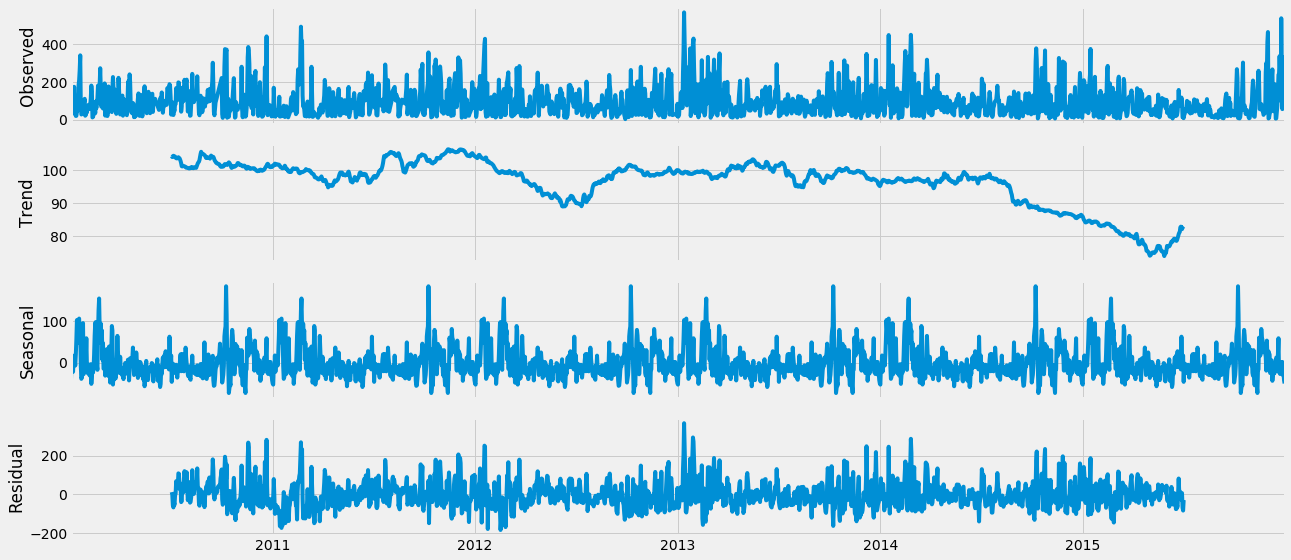

In [0]:
decomposition = sm.tsa.seasonal_decompose(df.pm25, model='additive', freq=365)
fig = decomposition.plot()
plt.show()

In [0]:
X = df.pm25.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.156816
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [0]:
time_series = df.pm25
train = time_series[:"2014"]
test = time_series["2015":]
p = [1, 2, 3]
d = [0]
q = [1, 2]
s = [365]

In [0]:
def arima_fit(time_series, orders):

    min_aic = 1000000000000000

    for order in orders:

        aic = ARIMA(time_series, order).fit().aic

        if aic < min_aic:

            min_aic = aic
            min_order = order

    print("Minimum AIC: {0:.2f}".format(min_aic))
    print("Order: " + str(min_order))

    return(min_aic, min_order)

In [0]:
def sarima_fit(time_series, orders, orders_seasonal):

    min_aic = 100000000000000
        
    for order in orders:

        for order_seasonal in orders_seasonal:

            print(order, order_seasonal)

            aic = sm.tsa.statespace.SARIMAX(time_series, order=order, seasonal_order=order_seasonal, enforce_stationarity=False, enforce_invertibility=False).fit().aic

            if aic < min_aic:
                min_aic = aic
                min_order = order
                min_order_seasonal = order_seasonal

    print("Minimum AIC: {0:.2f}".format(min_aic))
    print("Order: " + str(min_order))
    print("Order Seasonal: " + str(min_order_seasonal))

    return(min_aic, min_order, min_order_seasonal)

In [0]:
def arima_fit_with_gridsearch(time_series, p, d, q, s=None):

    orders = list(itertools.product(p, d, q))

    if s:

        orders_seasonal = list(itertools.product(p, d, q, s))        
        min_aic, min_order, min_order_seasonal = sarima_fit(time_series, orders, orders_seasonal)
        return(min_aic, min_order, min_order_seasonal)

    else:

        min_aic, min_order =  arima_fit(time_series, orders)
        return(min_aic, min_order)

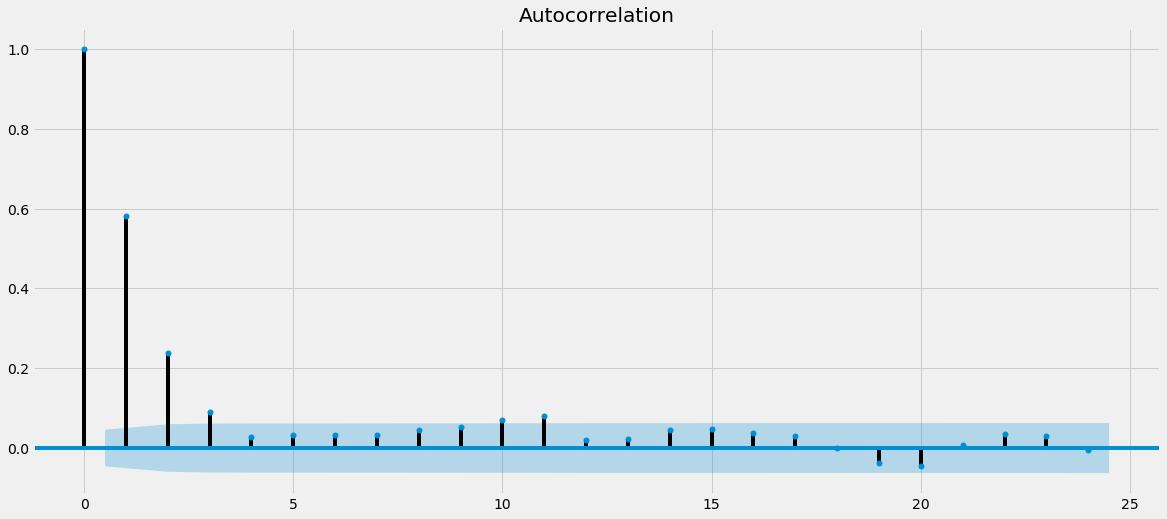

In [118]:
sm.graphics.tsa.plot_acf(train, lags=24);

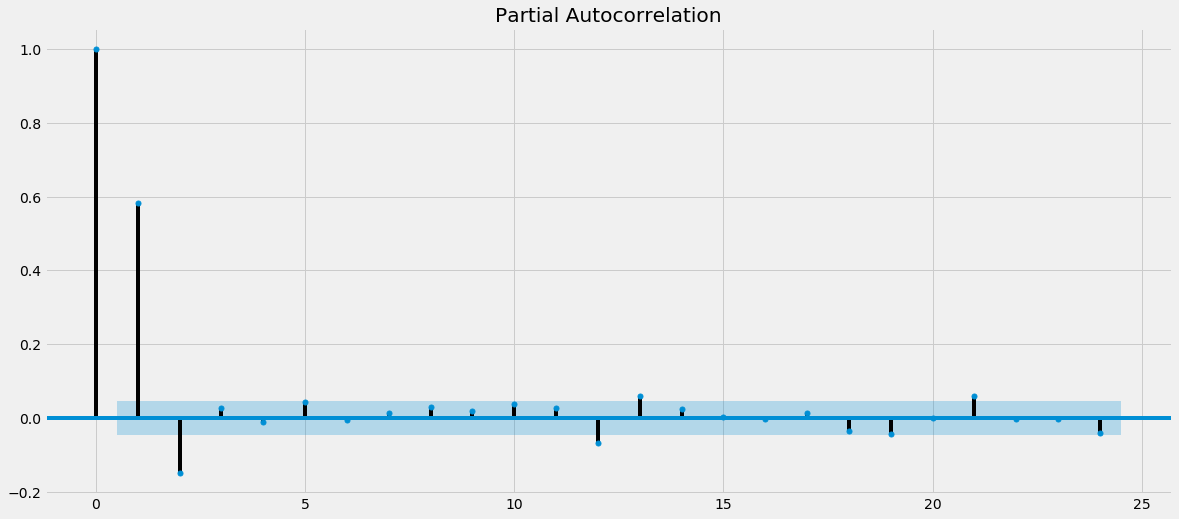

In [119]:
sm.graphics.tsa.plot_pacf(train, lags=24);

In [132]:
min_arima_aic, min_arima_order = arima_fit_with_gridsearch(time_series, p, d, q);

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

Minimum AIC: 24273.49
Order: (2, 0, 2)


In [133]:
results = ARIMA(time_series, order=(2, 0, 2)).fit()
results.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   pm25   No. Observations:                 2190
Model:                     ARMA(2, 2)   Log Likelihood              -12130.745
Method:                       css-mle   S.D. of innovations             61.565
Date:                Wed, 04 Mar 2020   AIC                          24273.489
Time:                        04:28:07   BIC                          24307.639
Sample:                    01-02-2010   HQIC                         24285.971
                         - 12-31-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.3215      5.005     19.247      0.000      86.513     106.130
ar.L1.pm25     1.3423      0.039     34.347      0.000       1.266       1.419
ar.L2.pm25    -0.3541      0.037     -9.631      0.000      -0.426      -0.282
ma.L1.pm25    -0.6793      0.040    -17.079      0.000      -0.757      -0.601
ma.L2.pm25    -0.2754      0.034     -8.009      0.000      -0.343      -0.208
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0188           +0.0000j            1.0188            0.0000
AR.2            2.7720           +0.0000j            2.7720            0.0000
MA.1            1.0366           +0.0000j            1.0366            0.0000
MA.2           -3.5030           +0.0000j            3.5030            0.5000
-----------------------------------------------------------------------------
"""

In [0]:
pred = results.predict(dynamic=False, start="2015-01-01")

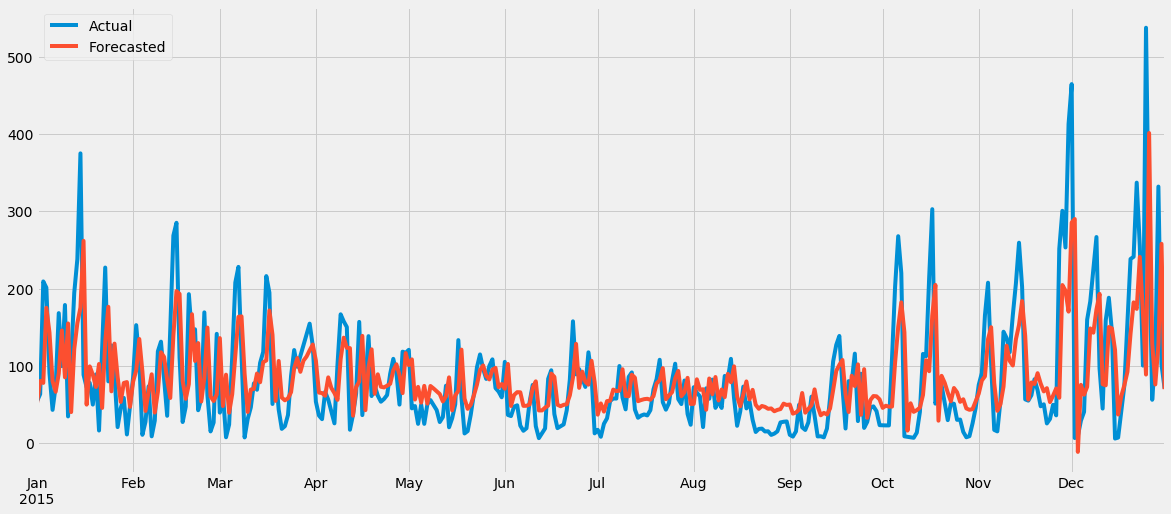

In [138]:
test.plot();
pred.plot();
plt.legend(["Actual", "Forecasted"])

In [139]:
mse = ((test - pred)**2).mean()
print("MSE: " + str(mse))
print("RMSE: " + str(mse**0.5))

MSE: 3793.2910433095776
RMSE: 61.589699165603804


### SARIMA

In [0]:
min_sarima_aic, min_sarima_order, min_sarima_order_seasonal = arima_fit_with_gridsearch(time_series, p, d, q, s)

### Long Short-Term Memory (LSTM) Neural Networks

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/Users/kevinlimkrailassiri/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [0]:
# Generate df_LSTM to feed into LSTM model:
def create_LSTM(dataset, timesteps, features, targets):
    
    # dataset is the dataframe from which X and y will be extracted
    # timesteps is the number of time steps in the past that will be used to calculate y
    # features is the number of parameters in X
    # targets is the number of parameters in y
    # create_LSTM() outputs df_LSTM_X and df_LSTM_y
    
    df_LSTM = pd.DataFrame()
    for tt in range(-timesteps + 1, 1, 1):
        df_shifted_X = dataset[dataset.columns[0:features]].shift(-tt).copy()
        df_shifted_X.columns = ['X_' + var + '(t' + str(tt) + ')' for var in df_shifted_X.columns]
        for col in df_shifted_X.columns:
            df_LSTM[col] = df_shifted_X[col]
    df_shifted_y = dataset[dataset.columns[0:targets]].shift(-tt-1).copy()
    df_shifted_y.columns = ['y_' + var + '(t' + str(tt+1) + ')' for var in df_shifted_y.columns]
    for col in df_shifted_y.columns:
        df_LSTM[col] = df_shifted_y[col]
    df_LSTM.dropna(inplace=True)
    df_LSTM_X = df_LSTM[df_LSTM.columns[:-targets]]
    df_LSTM_y = df_LSTM[df_LSTM.columns[-targets:]]
    return(df_LSTM_X, df_LSTM_y)

(1270, 365, 3) (540, 365, 3)
Completing Epoch #1... Train RMSE = 77.85, Test RMSE = 77.31
Completing Epoch #2... Train RMSE = 77.76, Test RMSE = 77.06
Completing Epoch #3... Train RMSE = 77.72, Test RMSE = 76.99
Completing Epoch #4... Train RMSE = 77.7, Test RMSE = 76.94
Completing Epoch #5... Train RMSE = 77.68, Test RMSE = 76.89
Completing Epoch #6... Train RMSE = 77.66, Test RMSE = 76.84
Completing Epoch #7... Train RMSE = 77.64, Test RMSE = 76.78
Completing Epoch #8... Train RMSE = 77.61, Test RMSE = 76.69
Completing Epoch #9... Train RMSE = 77.56, Test RMSE = 76.56
Completing Epoch #10... Train RMSE = 77.51, Test RMSE = 76.44
Completing Epoch #11... Train RMSE = 77.46, Test RMSE = 76.36
Completing Epoch #12... Train RMSE = 77.41, Test RMSE = 76.27
Completing Epoch #13... Train RMSE = 77.35, Test RMSE = 76.15
Completing Epoch #14... Train RMSE = 77.26, Test RMSE = 75.98
Completing Epoch #15... Train RMSE = 77.17, Test RMSE = 75.78
Completing Epoch #16... Train RMSE = 77.06, Test RM

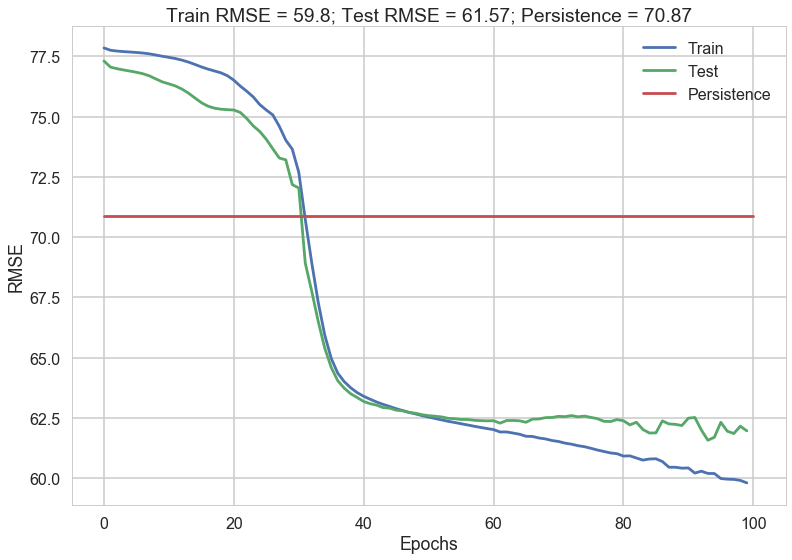

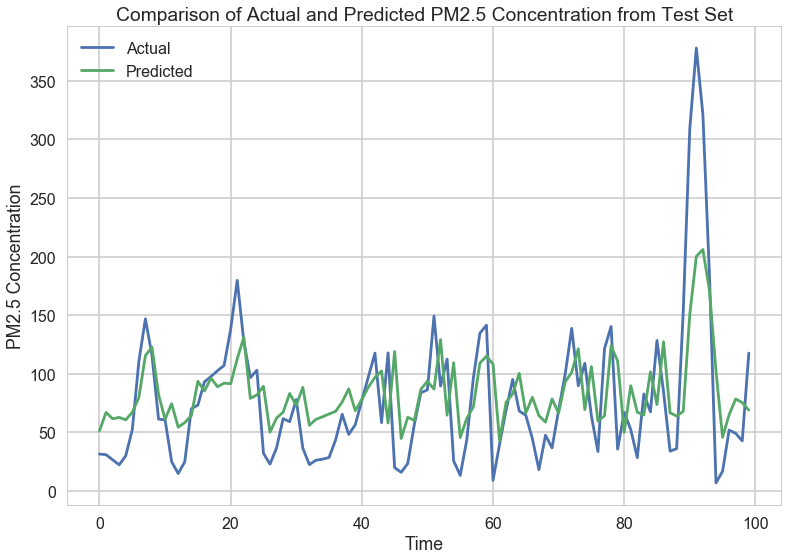

In [0]:
#### DESIGN NETWORK ####
timesteps = 365
features, targets = 3, 1

train_fraction = 0.7

batch_size = 10
neurons = 10
nb_epoch = 100
stacks = 3
########################

LSTM_X, LSTM_y = create_LSTM(df_daily, timesteps, features, targets)

normalizer_X = MinMaxScaler(feature_range = (0, 1))
normalizer_y = MinMaxScaler(feature_range = (0, 1))

normalized_X = normalizer_X.fit_transform(LSTM_X)
normalized_y = normalizer_y.fit_transform(LSTM_y)

train_rows = int(normalized_X.shape[0] * train_fraction/10)*10  # later replace '10' with batch_size?
test_rows = int(normalized_X.shape[0] * (1 - train_fraction)/10)*10

X_train = normalized_X[-(train_rows + test_rows):-test_rows, :]
y_train = normalized_y[-(train_rows + test_rows):-test_rows, :]

X_test = normalized_X[-test_rows:, :]
y_test = normalized_y[-test_rows:, :]

### Reshape into new array with (observations, timesteps, features)

X_train = X_train.reshape((train_rows, timesteps, features))
X_test = X_test.reshape((test_rows, timesteps, features))

print(X_train.shape, X_test.shape)

### Build model

model = Sequential()

if stacks == 1:
    model.add(LSTM(neurons, input_shape = (timesteps, features)))
elif stacks == 2:
    model.add(LSTM(neurons, batch_input_shape = (batch_size, timesteps, features), return_sequences = True, stateful = True))
    model.add(LSTM(neurons, stateful = True))
else:
    model.add(LSTM(neurons, batch_input_shape = (batch_size, timesteps, features), return_sequences = True, stateful = True))
    for ii in range(stacks - 2):
        model.add(LSTM(neurons, return_sequences = True, stateful = True))
    model.add(LSTM(neurons, stateful = True))      
    
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer = 'adam')

### Fit X and predict y

rmse_train, rmse_test, rmse_persistence = [], [], []

noninv_y_train = normalizer_y.inverse_transform(y_train)
noninv_y_test = normalizer_y.inverse_transform(y_test)
rmse_persistence = np.sqrt(mean_squared_error(noninv_y_test[:-1], noninv_y_test[1:]))

for ii in range(nb_epoch):
    model.fit(X_train, y_train, epochs = 1, batch_size = batch_size, verbose = 0, shuffle = False)
    y_train_predict = model.predict(X_train, batch_size = batch_size)
    y_test_predict = model.predict(X_test, batch_size = batch_size)
    
    # Inverse Transform all y's
    noninv_y_train_predict = normalizer_y.inverse_transform(y_train_predict)
    noninv_y_test_predict = normalizer_y.inverse_transform(y_test_predict)

    # Calculate RMSE
    rmse_train.append(np.sqrt(mean_squared_error(noninv_y_train, noninv_y_train_predict)))
    rmse_test.append(np.sqrt(mean_squared_error(noninv_y_test, noninv_y_test_predict)))
    
    print('Completing Epoch #' + str(ii + 1) + '... Train RMSE = ' + str(round(rmse_train[-1],2)) + ', Test RMSE = '
        + str(round(rmse_test[-1],2)))
    
    model.reset_states()

### Plot RMSE for train and test sets as function of epochs    
    
plt.figure()
plt.plot(rmse_train, label='Train')
plt.plot(rmse_test, label='Test')
plt.plot([0, nb_epoch], [rmse_persistence, rmse_persistence], label='Persistence')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train RMSE = ' + str(round(min(rmse_train),2)) + '; Test RMSE = ' + str(round(min(rmse_test),2)) + '; Persistence = ' + str(round(rmse_persistence,2)))
#plt.text(nb_epoch/2, rmse_persistence-4, ' Prior time steps = ' + str(timesteps) + '\n Train fraction = ' + str(train_fraction) 
        #+ '\n Batch size = ' + str(batch_size) + '\n Neurons = ' + str(neurons) + '\n Epochs = ' + str(nb_epoch)
        #+ '\n Stacks = ' + str(stacks))

### Plot actual and predicted y

plt.figure()
plt.plot(noninv_y_test[0:100], label = 'Actual')
plt.plot(noninv_y_test_predict[0:100], label = 'Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.title('Comparison of Actual and Predicted PM2.5 Concentration from Test Set')

In [0]:
# Prepare a dataframe to plot actual PM2.5 concentration with their predicted AQI classification

y_test_plot = pd.DataFrame(
    {'pm25actual': noninv_y_test.flatten(),
     'pm25predicted': noninv_y_test_predict.flatten()
    })

In [0]:
y_test_plot.head()

,pm25actual,pm25predicted
0,31.375000,51.210537
1,30.833333,66.932777
2,26.500000,61.528152
3,22.166667,62.659866
4,29.916667,60.579308


In [0]:
# Classifies the PM2.5 concentration into one of the 6 AQI classifications

def AQIclassifier(pm25):
    AQI = []
    for ii in pm25:
        if ii <= 50:
            AQI.append(1)
        elif ii > 50 and ii <= 100:
            AQI.append(2)
        elif ii > 100 and ii <= 150:
            AQI.append(3)
        elif ii > 150 and ii <= 200:
            AQI.append(4)
        elif ii > 200 and ii <= 300:
            AQI.append(5)
        else:
            AQI.append(6)
    return AQI

AQIactual = AQIclassifier(noninv_y_test)
AQIpredicted = AQIclassifier(noninv_y_test_predict)

In [0]:
y_test_plot['AQIactual'] = AQIactual
y_test_plot['AQIpredicted'] = AQIpredicted

In [0]:
# This is the number of points out of 540 that are correctly characterized by the LSTM model.

sum(y_test_plot['AQIactual'] == y_test_plot['AQIpredicted'])

168

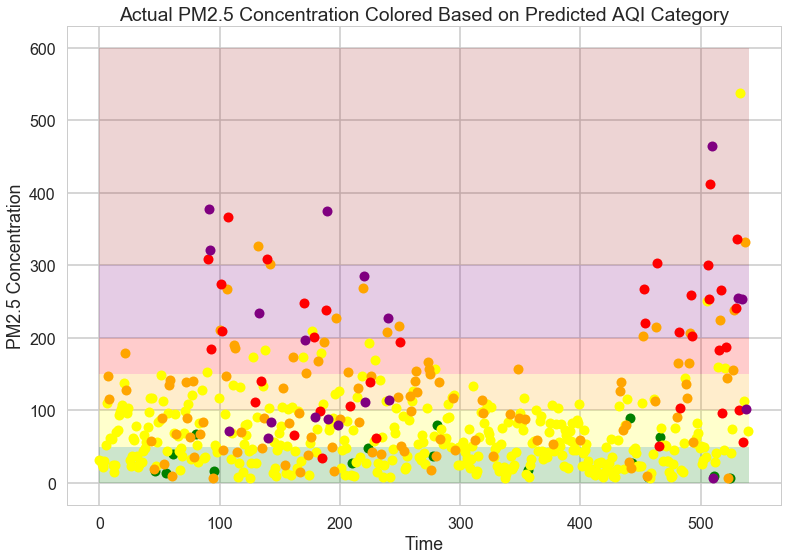

In [0]:
# Plot actual PM2.5 concentration with color based on the predicted AQI classification

fig, ax = plt.subplots()

ax.fill_between([0,540], 0, 50, facecolor='green', alpha = .2, interpolate=True)
ax.fill_between([0,540], 50, 100, facecolor='yellow', alpha = .2, interpolate=True)
ax.fill_between([0,540], 100, 150, facecolor='orange', alpha = .2, interpolate=True)
ax.fill_between([0,540], 150, 200, facecolor='red', alpha = .2, interpolate=True)
ax.fill_between([0,540], 200, 300, facecolor='purple', alpha = .2, interpolate=True)
ax.fill_between([0,540], 300, 600, facecolor='brown', alpha = .2, interpolate=True)

plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 1]['pm25actual'],'.',color='green',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 2]['pm25actual'],'.',color='yellow',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 3]['pm25actual'],'.',color='orange',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 4]['pm25actual'],'.',color='red',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 5]['pm25actual'],'.',color='purple',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 6]['pm25actual'],'.',color='brown',markersize = 20)

plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.title('Actual PM2.5 Concentration Colored Based on Predicted AQI Category')